In [32]:
import sys
import os
import numpy as np
import keras
import tensorflow as tf
import keras.backend as K
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import time

In [2]:
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../tests'))

from keras2c.keras2c_main import k2c

def build_and_run(name, return_output=False):
    ccflags = '-Ofast -std=c99 -I./include/'
    cc = 'gcc ' + ccflags + '-I' + name + '.h ' + ' -o ' + name + ' ' + \
        './include/k2c_activations.c ' + \
        './include/k2c_convolution_layers.c ' + \
        './include/k2c_core_layers.c ' + \
        './include/k2c_embedding_layers.c ' + \
        './include/k2c_helper_functions.c ' + \
        './include/k2c_merge_layers.c ' + \
        './include/k2c_normalization_layers.c ' + \
        './include/k2c_pooling_layers.c ' + \
        './include/k2c_recurrent_layers.c ' + \
        name + '.c ' + name + '_test_suite.c -lm'
    buildcode = subprocess.run(cc.split(),capture_output=True,text=True)
    if not buildcode.returncode:
        proc_output = subprocess.run(['./' + name],capture_output=True,text=True)
        rcode = proc_output.returncode
        if not rcode and not os.environ.get('CI'):
            subprocess.run('rm ' + name + '*', shell=True)
        if return_output:
            return proc_output
        else:
            return rcode
    else:
        return buildcode

os.chdir('../')
os.getcwd()

'/home/fouriest/SCHOOL/Princeton/PPPL/keras2c'

In [30]:
num_cores = 1
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                        inter_op_parallelism_threads=num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0})
session = tf.Session(config=config)
K.set_session(session)

In [33]:
%matplotlib inline
font={'family': 'DejaVu Serif',
      'size': 18}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

In [71]:
def time_model(model,num_tests):
    k2c(model,'foo',num_tests=num_tests,malloc=False,verbose=False)
    out = build_and_run('foo',True)
    ctime = float(out.stdout.split('\n')[0].split(' ')[-3])
    inp = np.random.random((num_tests,*model.input_shape[1:]))
    nparams = model.count_params()
    t0 = time.time_ns()
    for i in range(50):
        foo = model.predict(inp[i,np.newaxis,:])
    t1 = time.time_ns()
    pytime = (t1-t0)/10**9/num_tests
    return nparams, ctime, pytime

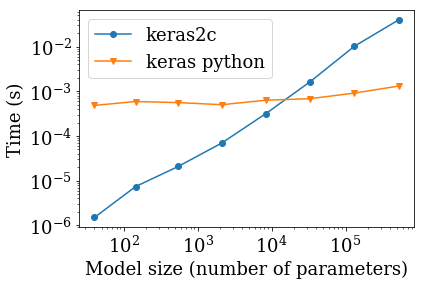

In [81]:
"""Dense Model"""
size = []
ctimes = []
pytimes = []
num_tests = 50
dims = [4,8,16,32,64,128,256,512,1024]
indims = dims[:-1]
outdims = dims[1:]
for indim,dim in zip(indims,outdims):
    inshp=(50,indim)
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(dim,input_shape=inshp))
    model.build()
    nparams, ctime, pytime = time_model(model,num_tests)
    size.append(nparams)
    ctimes.append(ctime)
    pytimes.append(pytime)

plt.loglog(size,ctimes,'-o',size,pytimes,'-v')
plt.ylabel('Time (s)')
plt.xlabel('Model size (number of parameters)')
plt.legend(['keras2c','keras python'])

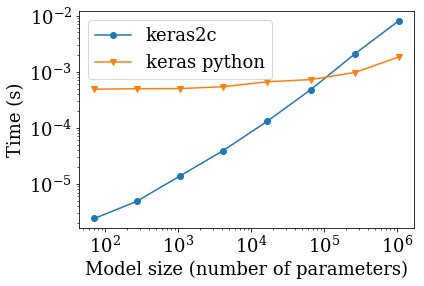

In [82]:
"""Conv1D Model"""
size = []
ctimes = []
pytimes = []
num_tests = 50
dims = [4,8,16,32,64,128,256,512,1024]
indims = dims[:-1]
outdims = dims[1:]
for indim,dim in zip(indims,outdims):
    inshp=(50,indim)
    model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(dim,kernel_size=2,input_shape=inshp))
    model.build()
    nparams, ctime, pytime = time_model(model,num_tests)
    size.append(nparams)
    ctimes.append(ctime)
    pytimes.append(pytime)

plt.loglog(size,ctimes,'-o',size,pytimes,'-v')
plt.ylabel('Time (s)')
plt.xlabel('Model size (number of parameters)')
plt.legend(['keras2c','keras python'])

In [83]:
"""Conv2D Model"""
size = []
ctimes = []
pytimes = []
num_tests = 50
dims = [8,16,32,64,128,256,512]
indims = dims[:-1]
outdims = dims[1:]
for indim,dim in zip(indims,outdims):
    inshp=(64,64,indim)
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(dim,kernel_size=2,input_shape=inshp))
    model.build()
    nparams, ctime, pytime = time_model(model,num_tests)
    size.append(nparams)
    ctimes.append(ctime)
    pytimes.append(pytime)

plt.loglog(size,ctimes,'-o',size,pytimes,'-v')
plt.ylabel('Time (s)')
plt.xlabel('Model size (number of parameters)')
plt.legend(['keras2c','keras python'])

IndexError: list index out of range

In [ ]:
"""LSTM Model"""
size = []
ctimes = []
pytimes = []
num_tests = 50
dims = [8,16,32,64,128,256,512,1024]
indims = dims[:-1]
outdims = dims[1:]
for indim,dim in zip(indims,outdims):
    inshp=(20,indim)
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(dim,return_sequences=True,input_shape=inshp))
    model.build()
    nparams, ctime, pytime = time_model(model,num_tests)
    size.append(nparams)
    ctimes.append(ctime)
    pytimes.append(pytime)

plt.loglog(size,ctimes,'-o',size,pytimes,'-v')
plt.ylabel('Time (s)')
plt.xlabel('Model size (number of parameters)')
plt.legend(['keras2c','keras python'])

In [56]:
%timeit model.predict(inp[1,np.newaxis,:])

1.23 ms ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
